In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def imshow(images, titles, nrows=0, ncols=0, figsize=(15, 20)):
    """
    Plot multiple images with titles using matplotlib.

    images: list of np.ndarray
    titles: list of strings (same length as images)
    """
    if ncols == 0 and nrows == 0:
        ncols = len(images)
        nrows = 1
    if ncols == 0:
        ncols = int(np.ceil(len(images) / nrows))
    if nrows == 0:
        nrows = int(np.ceil(len(images) / ncols))

    fig, axeslist = plt.subplots(
        ncols=ncols, nrows=nrows, squeeze=False, figsize=figsize
    )

    for i, image in enumerate(images):
        ax = axeslist.ravel()[i]

        # if grayscale
        if image.ndim == 2:
            ax.imshow(image, cmap="gray", vmin=0, vmax=255)
        else:
            # assume color in RGB order
            ax.imshow(image)
        ax.set_title(titles[i])
        ax.set_axis_off()

    plt.tight_layout()
    plt.show()


In [ ]:
def img_path_to_label_path(img_path):
    dir_name, file_name = os.path.split(img_path)
    base, _ = os.path.splitext(file_name)
    return os.path.join(dir_name, base + ".txt")

In [ ]:
import os
import cv2
import numpy as np

def load_yolo_player_boxes(label_path, img_shape, player_class_id=3):
    """
    Read YOLO txt file and return a list of player boxes (x1,y1,x2,y2) in pixel coords.

    label_path: path to .txt file
    img_shape: shape of the image (H, W, C) or (H, W)
    player_class_id: int, the class ID for players in your dataset (3 here)
    """
    if not os.path.exists(label_path):
        print(f"[WARN] Label file not found: {label_path}")
        return []

    if len(img_shape) == 3:
        H, W, _ = img_shape
    else:
        H, W = img_shape

    boxes = []

    with open(label_path, "r") as f:
        for line in f:
            line = line.strip()
            if not line:
                continue

            parts = line.split()
            if len(parts) < 5:
                continue

            cls_id = int(float(parts[0]))
            if cls_id != player_class_id:
                continue  # skip non-player classes

            cx, cy, w, h = map(float, parts[1:5])

            # convert normalized to pixel coords
            cx_px = cx * W
            cy_px = cy * H
            w_px  = w  * W
            h_px  = h  * H

            x1 = int(cx_px - w_px / 2)
            y1 = int(cy_px - h_px / 2)
            x2 = int(cx_px + w_px / 2)
            y2 = int(cy_px + h_px / 2)

            # clamp to image bounds
            x1 = max(0, min(W - 1, x1))
            y1 = max(0, min(H - 1, y1))
            x2 = max(0, min(W - 1, x2))
            y2 = max(0, min(H - 1, y2))

            boxes.append((x1, y1, x2, y2))

    return boxes


In [ ]:
def get_player_mask_from_yolo_box(frame, box):
    """
    frame: full BGR image (H, W, 3)
    box: (x1, y1, x2, y2) from YOLO in pixel coords

    returns:
        mask     : (h, w) uint8, 0/255, silhouette of player in the crop
        crop     : (h, w, 3) BGR crop
        edges    : (h, w) uint8, raw Canny edges
        edges_cl : (h, w) uint8, edges after dilate + close
    """
    H, W = frame.shape[:2]
    x1, y1, x2, y2 = box

    # 1) Clamp box to image bounds
    x1 = max(0, x1); y1 = max(0, y1)
    x2 = min(W - 1, x2); y2 = min(H - 1, y2)

    # 2) Extract crop
    crop = frame[y1:y2, x1:x2]
    if crop.size == 0:
        empty = np.zeros((0, 0), dtype=np.uint8)
        return empty, crop, empty, empty

    # 3) Gray + blur
    gray = cv2.cvtColor(crop, cv2.COLOR_BGR2GRAY)
    #gray = cv2.GaussianBlur(gray, (5, 5), 0)

    # 4) Canny edges
    edges = cv2.Canny(gray, 50, 150)

    # 5) Close gaps (dilate + close)
    kernel = np.ones((3, 3), np.uint8)
    edges_dil = cv2.dilate(edges, kernel, iterations=1)
    edges_cl  = cv2.morphologyEx(edges_dil, cv2.MORPH_CLOSE, kernel, iterations=5)

    # 6) Find contours
    contours, _ = cv2.findContours(edges_cl, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    h, w = gray.shape[:2]
    mask = np.zeros((h, w), dtype=np.uint8)

    if not contours:
        return mask, crop, edges, edges_cl

    # 7) Keep largest contour
    largest = max(contours, key=cv2.contourArea)

    # 8) Fill it → silhouette
    cv2.drawContours(mask, [largest], contourIdx=-1, color=255, thickness=-1)

    # 9) Optional cleanup
    mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel, iterations=1)

    return mask, crop, edges, edges_cl


Found player boxes: [(585, 629, 750, 928), (318, 588, 572, 890), (194, 319, 349, 617), (931, 213, 1095, 525), (1102, 348, 1312, 609), (1141, 9, 1274, 309), (1358, 506, 1595, 833)]


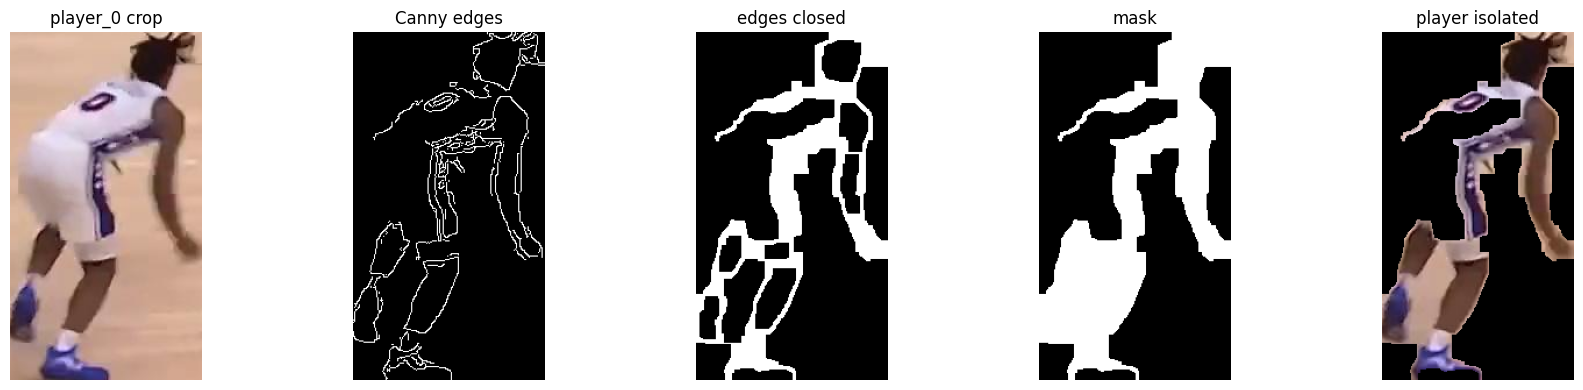

Saved player 0 images to: /content/player_saves


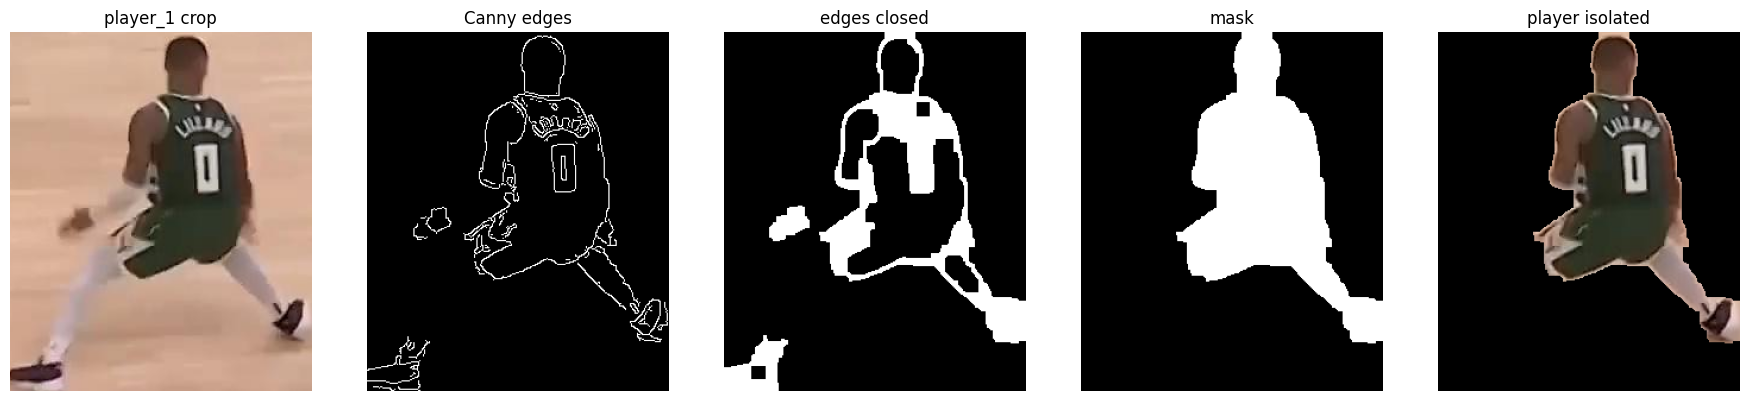

Saved player 1 images to: /content/player_saves


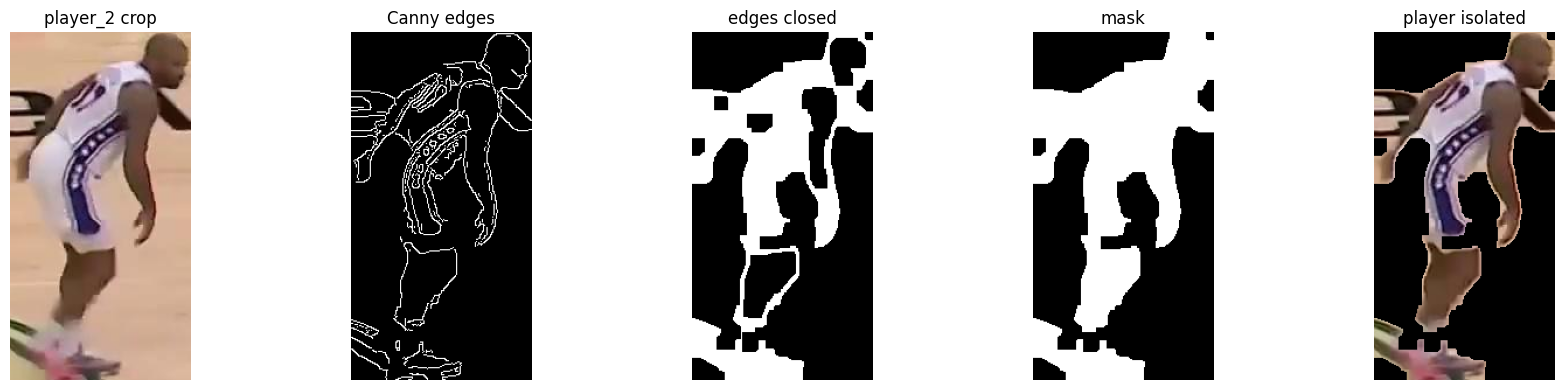

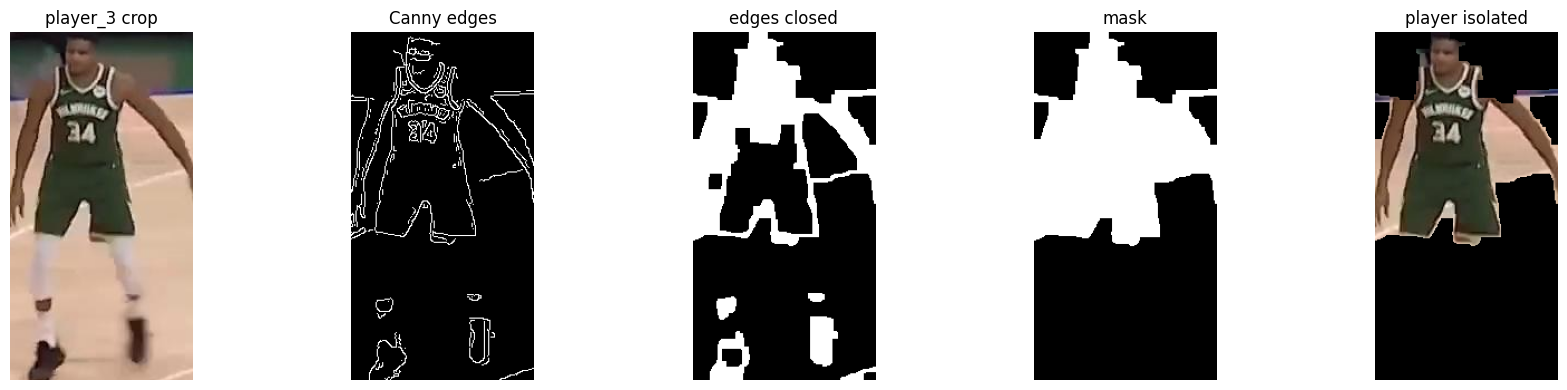

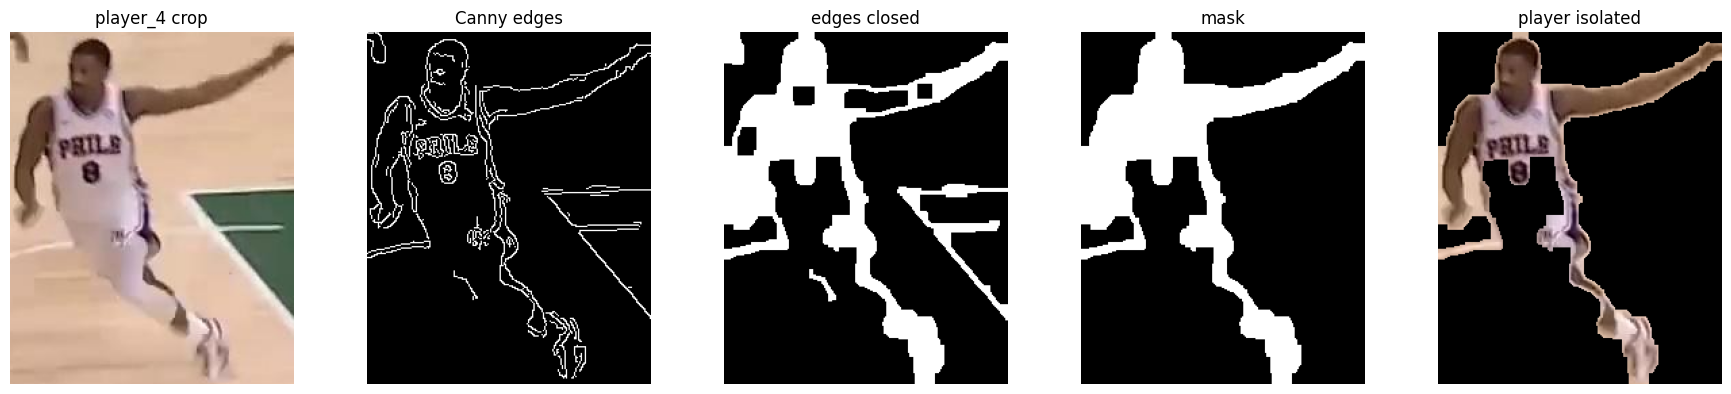

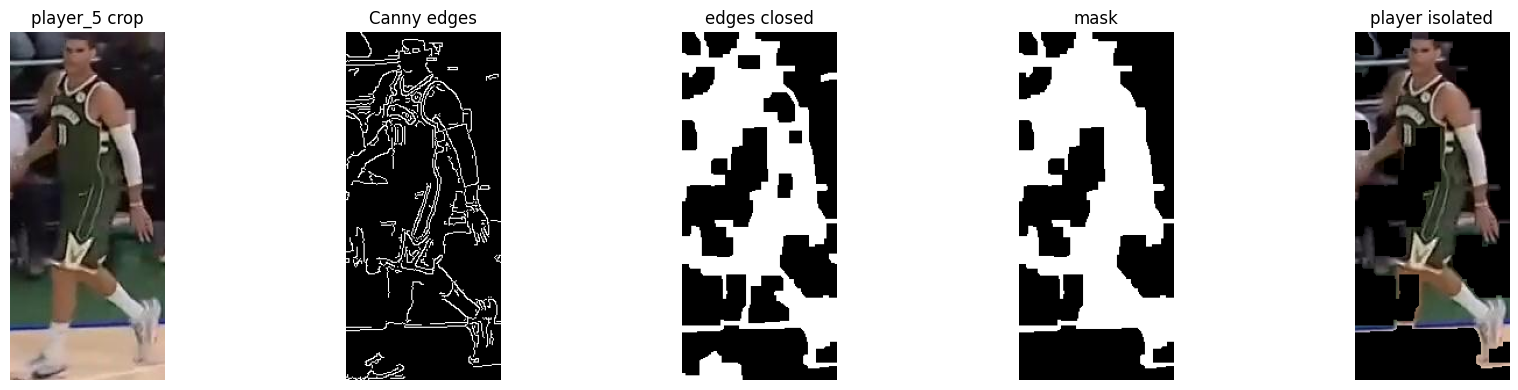

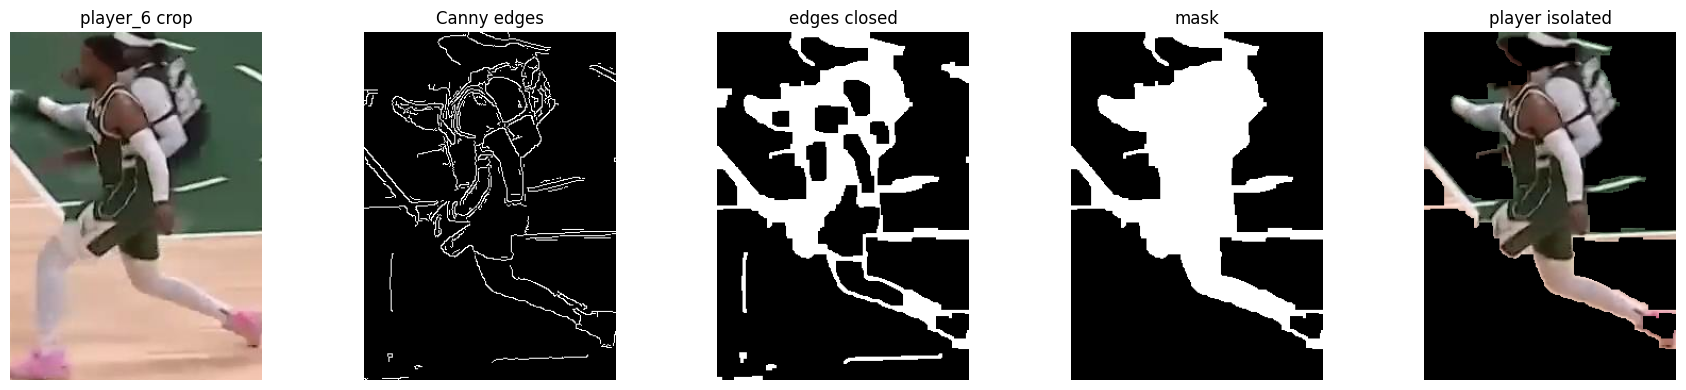

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# your imshow
def imshow(images, titles, nrows=0, ncols=0, figsize=(15, 20)):
    if ncols == 0 and nrows == 0:
        ncols = len(images)
        nrows = 1
    if ncols == 0:
        ncols = int(np.ceil(len(images) / nrows))
    if nrows == 0:
        nrows = int(np.ceil(len(images) / ncols))

    fig, axeslist = plt.subplots(
        ncols=ncols, nrows=nrows, squeeze=False, figsize=figsize
    )

    for i, image in enumerate(images):
        ax = axeslist.ravel()[i]

        if image.ndim == 2:  # grayscale (mask)
            ax.imshow(image, cmap="gray", vmin=0, vmax=255)
        else:                # color (assume RGB)
            ax.imshow(image)

        ax.set_title(titles[i])
        ax.set_axis_off()

    plt.tight_layout()
    plt.show()


# ====== your existing code, adapted to matplotlib imshow ======

img_prev_path = "Image/frame_128_jpg.rf.bc29dc6ee2d722a5253e3297c53b95ac.jpg"
img_curr_path = "Image/frame_109_jpg.rf.0c6ddfae0c4bbc3aafdd0158d5998a09.jpg"

label_prev_path = img_path_to_label_path(img_prev_path)
label_curr_path = img_path_to_label_path(img_curr_path)

# Example on previous frame
frame_prev = cv2.imread(img_prev_path)

player_boxes_prev = load_yolo_player_boxes(
    label_prev_path, frame_prev.shape, player_class_id=3
)

print("Found player boxes:", player_boxes_prev)

for i, box in enumerate(player_boxes_prev):
    mask, crop, edges, edges_cl = get_player_mask_from_yolo_box(frame_prev, box)

    # BGR → RGB for matplotlib
    crop_rgb = cv2.cvtColor(crop, cv2.COLOR_BGR2RGB)

    player_only = crop.copy()
    player_only[mask == 0] = 0
    player_only_rgb = cv2.cvtColor(player_only, cv2.COLOR_BGR2RGB)

    images = [crop_rgb, edges, edges_cl, mask, player_only_rgb]
    titles = [
        f"player_{i} crop",
        "Canny edges",
        "edges closed",
        "mask",
        "player isolated"
    ]

    imshow(images, titles, nrows=1, ncols=5, figsize=(18, 4))


In [ ]:
import cv2
import numpy as np

def get_player_mask_grabcut_from_yolo_box(frame, box, iters=3, border=5):
    """
    Foreground/background segmentation inside YOLO box using GrabCut.

    frame: full BGR image (H, W, 3)
    box: (x1, y1, x2, y2) from YOLO
    iters: number of GrabCut iterations
    border: pixels at the crop border treated as probable background

    returns:
        mask_fg: (h, w) uint8, 0/255, player mask in crop coords
        crop:    (h, w, 3) BGR crop image
    """
    H, W = frame.shape[:2]
    x1, y1, x2, y2 = box

    # clamp box
    x1 = max(0, x1); y1 = max(0, y1)
    x2 = min(W - 1, x2); y2 = min(H - 1, y2)

    crop = frame[y1:y2, x1:x2]
    if crop.size == 0:
        return np.zeros((0, 0), np.uint8), crop

    h, w = crop.shape[:2]

    # GrabCut mask: 0=bg, 1=fg, 2=prob-bg, 3=prob-fg
    gc_mask = np.zeros((h, w), np.uint8)

    # Start by saying: everything is "probable foreground"
    gc_mask[:] = cv2.GC_PR_FGD

    # A small border is "probable background"
    b = border
    gc_mask[:b, :]  = cv2.GC_PR_BGD
    gc_mask[-b:, :] = cv2.GC_PR_BGD
    gc_mask[:, :b]  = cv2.GC_PR_BGD
    gc_mask[:, -b:] = cv2.GC_PR_BGD

    bgdModel = np.zeros((1, 65), np.float64)
    fgdModel = np.zeros((1, 65), np.float64)

    cv2.grabCut(
        crop,
        gc_mask,
        None,
        bgdModel,
        fgdModel,
        iters,
        mode=cv2.GC_INIT_WITH_MASK
    )

    # FG or PROB_FG → 255, else 0
    mask_fg = np.where(
        (gc_mask == cv2.GC_FGD) | (gc_mask == cv2.GC_PR_FGD),
        255, 0
    ).astype('uint8')

    # small cleanup
    kernel = np.ones((3, 3), np.uint8)
    mask_fg = cv2.morphologyEx(mask_fg, cv2.MORPH_OPEN, kernel, iterations=1)

    return mask_fg, crop


In [ ]:
def get_torso_box_by_distance(mask_fg, k=1.2):
    """
    Given a FG mask (0/255) inside a player crop,
    find the densest interior point via distance transform and build a torso-ish box.

    mask_fg: (h, w) uint8, 0/255
    k: scale factor for box size relative to max distance

    returns:
        (x_min, y_min, x_max, y_max) in crop coords, or None
    """
    if mask_fg.size == 0 or cv2.countNonZero(mask_fg) < 20:
        return None

    # binary 0/1
    bin_mask = (mask_fg > 0).astype(np.uint8)

    # L1 distance (4-connected, like your 4 vectors idea)
    dist = cv2.distanceTransform(bin_mask, distanceType=cv2.DIST_L1, maskSize=3)

    minVal, maxVal, minLoc, maxLoc = cv2.minMaxLoc(dist)
    if maxVal <= 0:
        return None

    cx, cy = maxLoc  # deepest interior pixel in crop coords
    R = maxVal       # distance to nearest background in 4-connected sense

    # build a square around (cx, cy)
    half = int(k * R)
    h, w = mask_fg.shape[:2]

    x_min = max(cx - half, 0)
    x_max = min(cx + half, w - 1)
    y_min = max(cy - half, 0)
    y_max = min(cy + half, h - 1)

    return (x_min, y_min, x_max, y_max)


Found player boxes: [(585, 629, 750, 928), (318, 588, 572, 890), (194, 319, 349, 617), (931, 213, 1095, 525), (1102, 348, 1312, 609), (1141, 9, 1274, 309), (1358, 506, 1595, 833)]


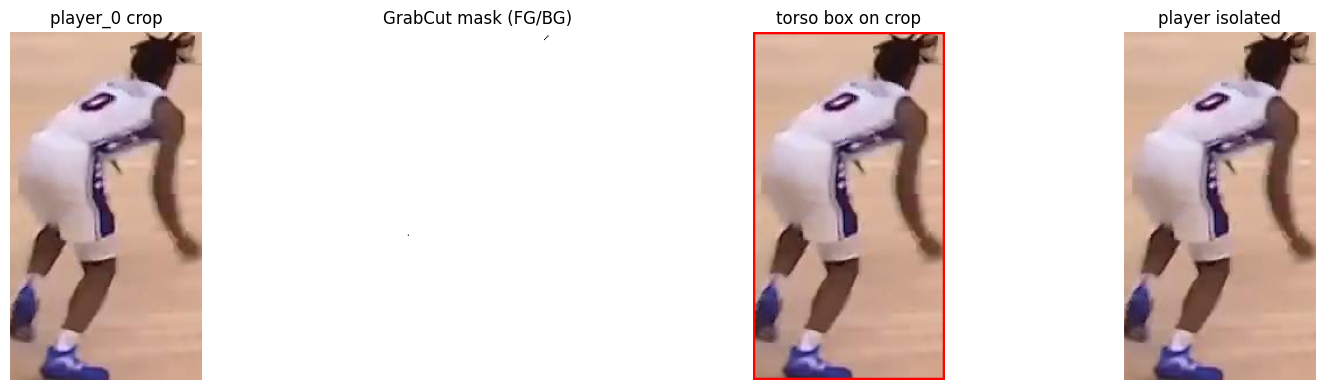

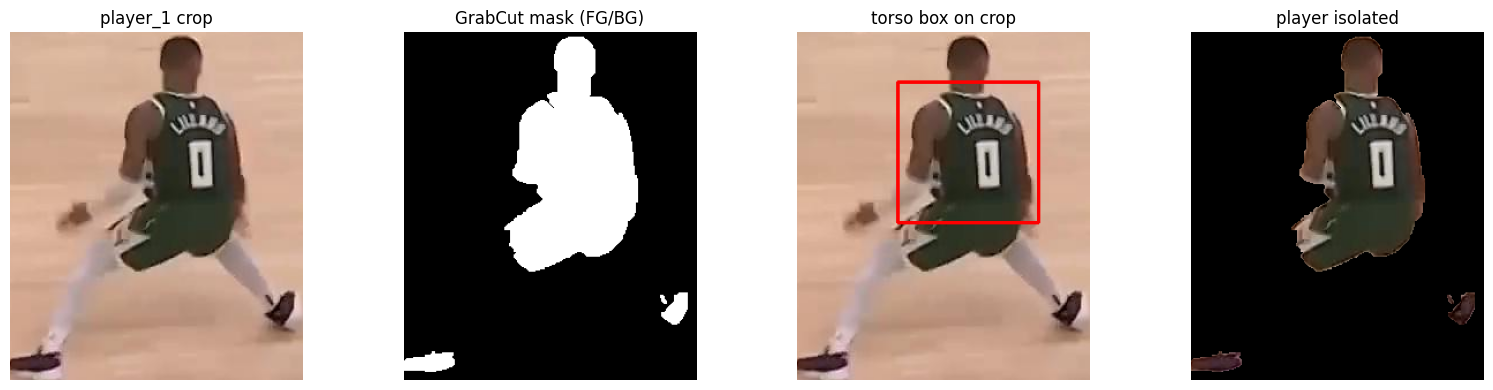

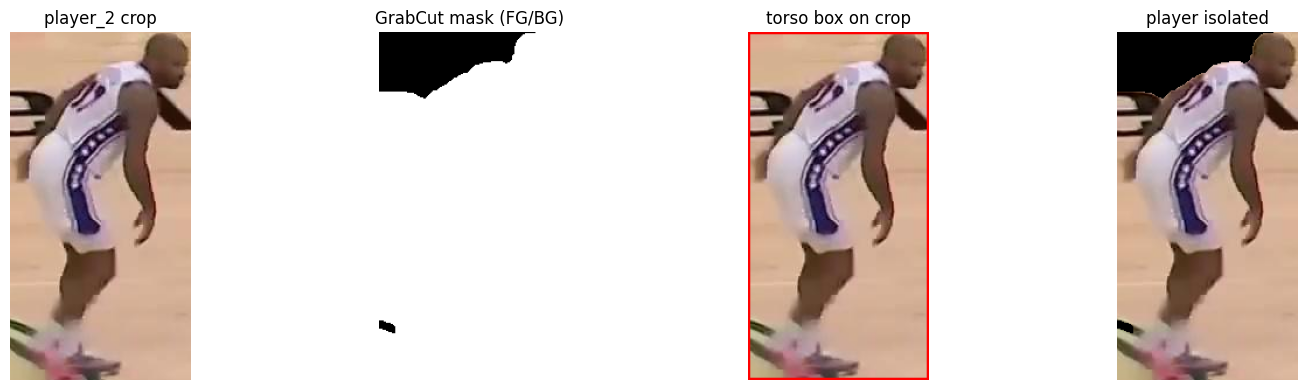

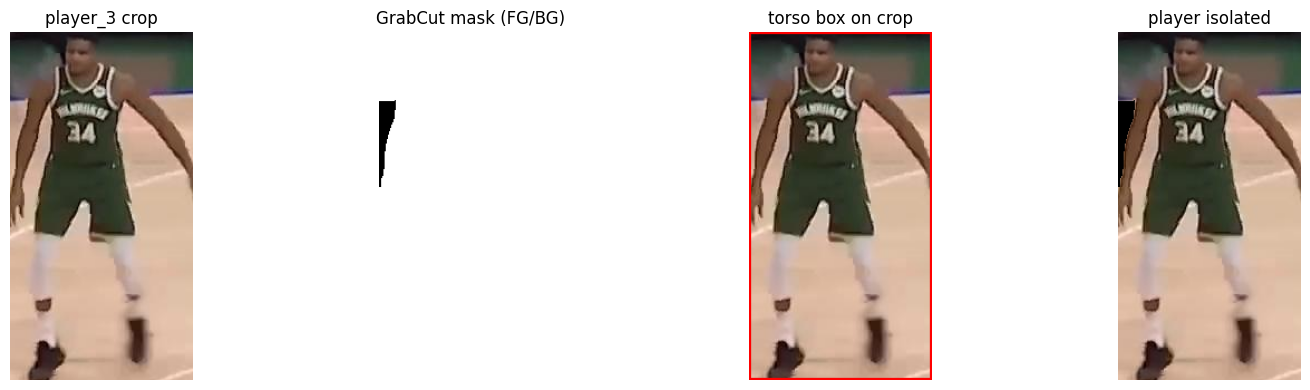

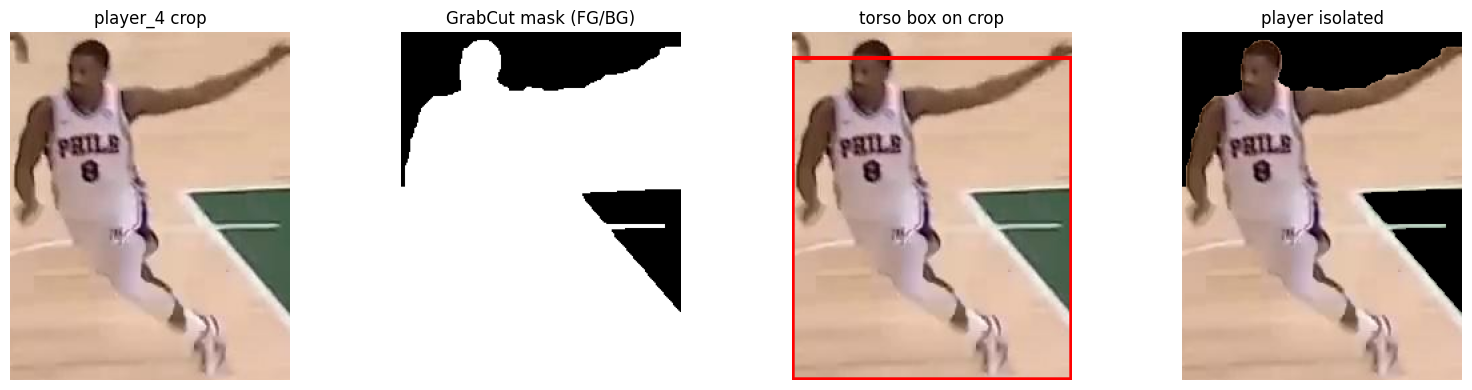

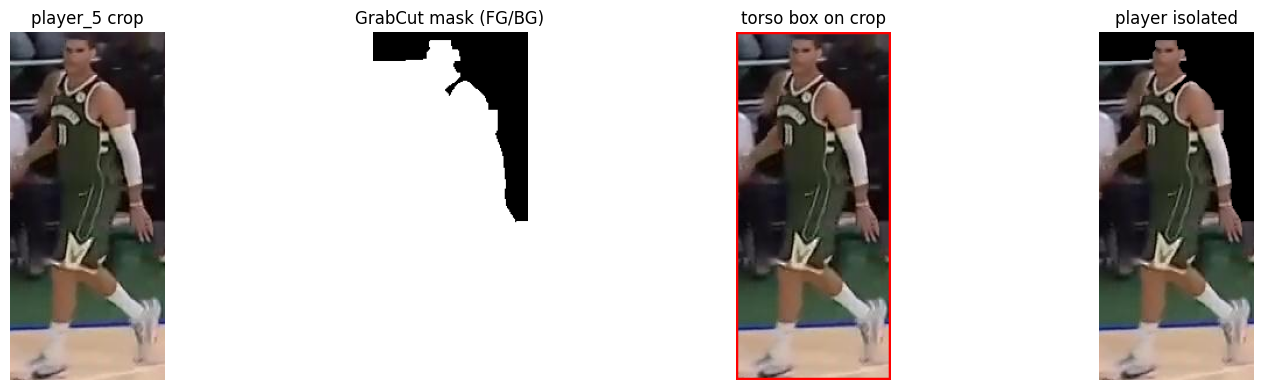

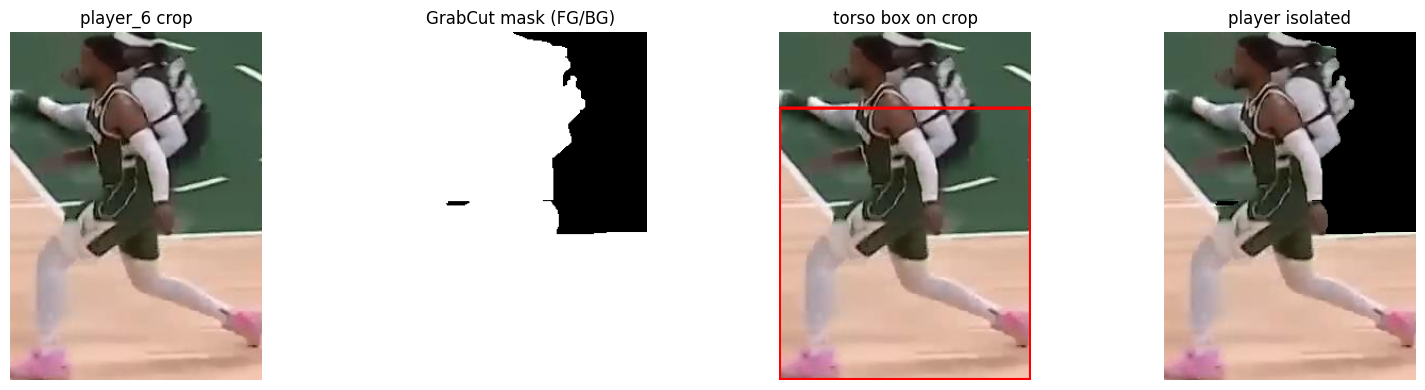

In [ ]:
player_boxes_prev = load_yolo_player_boxes(
    label_prev_path,
    frame_prev.shape,
    player_class_id=3
)

print("Found player boxes:", player_boxes_prev)

for i, box in enumerate(player_boxes_prev):
    # 2) segment player with GrabCut (graph-cut fg/bg)
    mask_fg, crop = get_player_mask_grabcut_from_yolo_box(frame_prev, box, iters=3, border=5)

    # 3) torso box in crop coords
    torso_crop_box = get_torso_box_by_distance(mask_fg, k=1.2)

    # visualize on the crop
    crop_vis = crop.copy()
    if torso_crop_box is not None:
        tx1, ty1, tx2, ty2 = torso_crop_box
        cv2.rectangle(crop_vis, (tx1, ty1), (tx2, ty2), (0, 0, 255), 2)

    player_only = crop.copy()
    player_only[mask_fg == 0] = 0

    # BGR → RGB
    crop_rgb        = cv2.cvtColor(crop, cv2.COLOR_BGR2RGB)
    crop_vis_rgb    = cv2.cvtColor(crop_vis, cv2.COLOR_BGR2RGB)
    player_only_rgb = cv2.cvtColor(player_only, cv2.COLOR_BGR2RGB)

    images = [crop_rgb, mask_fg, crop_vis_rgb, player_only_rgb]
    titles = [
        f"player_{i} crop",
        "GrabCut mask (FG/BG)",
        "torso box on crop",
        "player isolated"
    ]

    imshow(images, titles, nrows=1, ncols=4, figsize=(16, 4))

In [ ]:
import numpy as np
import cv2

def grabcut_player_from_box(frame, box, margin=20, iters=5):
    """
    frame: (H, W, 3) BGR image
    box: [x1, y1, x2, y2] from YOLO (player box)
    margin: extension around the box to give context
    """
    H, W = frame.shape[:2]
    x1, y1, x2, y2 = map(int, box)

    print("Running grabcut on box:", x1, y1, x2, y2)   # DEBUG

    # 1) Extended rectangle (working area)
    x1e = max(x1 - margin, 0)
    y1e = max(y1 - margin, 0)
    x2e = min(x2 + margin, W - 1)
    y2e = min(y2 + margin, H - 1)

    roi = frame[y1e:y2e, x1e:x2e].copy()
    h_roi, w_roi = roi.shape[:2]

    # 2) GrabCut mask and rect (in ROI coords)
    mask = np.zeros((h_roi, w_roi), np.uint8)

    # rect = original YOLO box in ROI coordinates
    rect_x = x1 - x1e
    rect_y = y1 - y1e
    rect_w = (x2 - x1)
    rect_h = (y2 - y1)
    rect = (rect_x, rect_y, rect_w, rect_h)

    bgdModel = np.zeros((1, 65), np.float64)
    fgdModel = np.zeros((1, 65), np.float64)

    # 3) Run GrabCut with RECT mode
    cv2.grabCut(
        roi, mask, rect,
        bgdModel, fgdModel,
        iters,
        cv2.GC_INIT_WITH_RECT
    )

    # 4) Build binary mask: FGD + PR_FGD
    roi_player_mask = np.where(
        (mask == cv2.GC_FGD) | (mask == cv2.GC_PR_FGD),
        1, 0
    ).astype("uint8")

    # 5) Paste back in full image mask
    full_mask = np.zeros((H, W), dtype=np.uint8)
    full_mask[y1e:y2e, x1e:x2e] = roi_player_mask

    player_rgb = frame * full_mask[:, :, None]

    return full_mask, player_rgb


Running grabcut on box: 245 594 380 905
Running grabcut on box: 557 551 633 802
Running grabcut on box: 632 500 755 777
Running grabcut on box: 689 479 815 761
Running grabcut on box: 836 326 916 559
Running grabcut on box: 300 257 372 483
Running grabcut on box: 993 247 1106 466
Running grabcut on box: 1232 213 1300 413
Running grabcut on box: 1221 292 1270 523
Running grabcut on box: 1381 307 1457 553


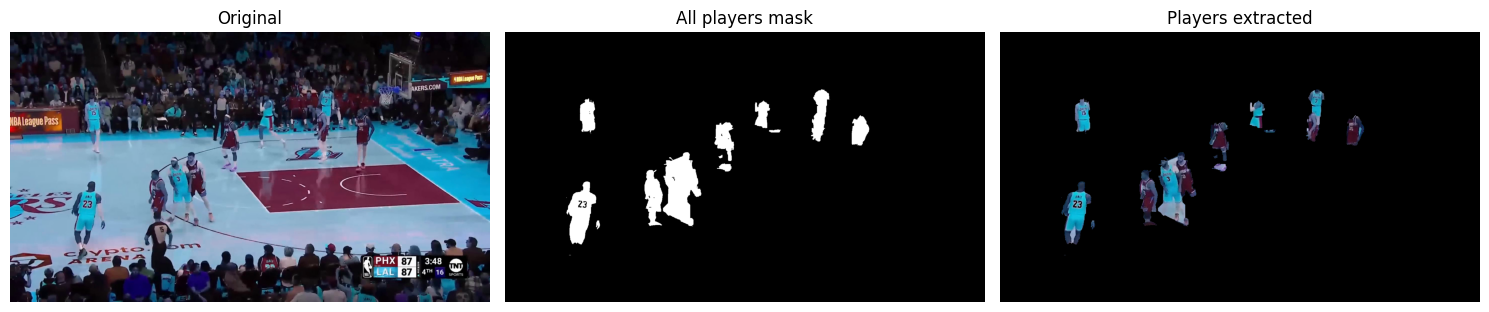

In [ ]:
img_prev_path = "Image/frame_210_jpg.rf.237c0dd380cee437b0c4455bb26750a7.jpg"
img_prev_path = "Image/frame_249_jpg.rf.d6db8409a8918a858fa75f950b5cc974.jpg"
img_curr_path = "Image/frame_129_jpg.rf.e1ca73139aed49cebbd887240b464a2c.jpg"

label_prev_path = img_path_to_label_path(img_prev_path)
label_curr_path = img_path_to_label_path(img_curr_path)



frame_prev = cv2.imread(img_prev_path)
player_boxes_prev = load_yolo_player_boxes(
    label_prev_path,
    frame_prev.shape,
    player_class_id=3
)

all_players_mask = np.zeros(frame_prev.shape[:2], dtype=np.uint8)

for box in player_boxes_prev:
    mask_i, _ = grabcut_player_from_box(frame_prev, box, margin=200, iters=7)
    all_players_mask = np.maximum(all_players_mask, mask_i)

players_rgb = frame_prev * all_players_mask[:, :, None]

# visualize (example)
imshow(
    [
        frame_prev,
        all_players_mask * 255,   # to see it as white/black
        players_rgb
    ],
    [
        "Original",
        "All players mask",
        "Players extracted"
    ]
)



In [ ]:
import numpy as np
import cv2

def player_color_feature_lab(frame, box, full_mask, min_pixels=50):
    """
    frame: (H, W, 3) BGR
    box: [x1, y1, x2, y2]
    full_mask: (H, W) binary mask for that player (0/1)
    returns: feature vector [a_mean, b_mean]
             (never None: falls back to whole box if mask is too small)
    """
    H, W = frame.shape[:2]
    x1, y1, x2, y2 = map(int, box)
    x1 = max(0, x1); y1 = max(0, y1)
    x2 = min(W, x2); y2 = min(H, y2)

    roi = frame[y1:y2, x1:x2]
    roi_mask = full_mask[y1:y2, x1:x2]

    # get masked pixels
    ys, xs = np.where(roi_mask == 1)

    # --- CASE 1: enough segmented pixels -> use them (best quality) ---
    if len(ys) >= min_pixels:
        roi_lab = cv2.cvtColor(roi, cv2.COLOR_BGR2LAB)
        L, A, B = cv2.split(roi_lab)

        a_vals = A[ys, xs].astype(np.float32)
        b_vals = B[ys, xs].astype(np.float32)

        a_mean = np.mean(a_vals)
        b_mean = np.mean(b_vals)

        return np.array([a_mean, b_mean], dtype=np.float32)

    # --- CASE 2: segmentation too small -> fallback: whole box color ---
    # (jersey usually dominates the box anyway)
    roi_lab = cv2.cvtColor(roi, cv2.COLOR_BGR2LAB)
    L, A, B = cv2.split(roi_lab)

    a_mean = float(np.mean(A))
    b_mean = float(np.mean(B))

    return np.array([a_mean, b_mean], dtype=np.float32)


In [ ]:
frame_prev = cv2.imread(img_prev_path)
player_boxes_prev = load_yolo_player_boxes(
    label_prev_path,
    frame_prev.shape,
    player_class_id=3
)

player_masks = []    # one full-image mask per player
features = []        # [a_mean, b_mean]
valid_indices = []   # indices of players that gave a valid feature

for idx, box in enumerate(player_boxes_prev):
    mask_i, _ = grabcut_player_from_box(frame_prev, box, margin=200, iters=5)
    feat = player_color_feature_lab(frame_prev, box, mask_i)

    if feat is not None:
        player_masks.append(mask_i)
        features.append(feat)
        valid_indices.append(idx)

features = np.array(features, dtype=np.float32)  # shape (M, 2) where M ≤ num players


Running grabcut on box: 245 594 380 905
Running grabcut on box: 557 551 633 802
Running grabcut on box: 632 500 755 777
Running grabcut on box: 689 479 815 761
Running grabcut on box: 836 326 916 559
Running grabcut on box: 300 257 372 483
Running grabcut on box: 993 247 1106 466
Running grabcut on box: 1232 213 1300 413
Running grabcut on box: 1221 292 1270 523
Running grabcut on box: 1381 307 1457 553


In [ ]:
def cluster_players_into_teams(features, K=2):
    """
    features: (M, 2) array of [a_mean, b_mean]
    returns: team_labels (M,) with values in {0, 1}
    """
    # criteria: stop after 100 iterations or epsilon = 1.0
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER,
                100, 1.0)

    # kmeans expects samples as float32
    Z = features.astype(np.float32)

    compactness, labels, centers = cv2.kmeans(
        Z,
        K,
        None,
        criteria,
        10,                  # attempts
        cv2.KMEANS_PP_CENTERS
    )
    # labels is (M,1)
    return labels.flatten(), centers

team_labels, centers = cluster_players_into_teams(features, K=2)


In [ ]:
player_team = {}  # key: original box index, value: team id 0 or 1

for local_i, orig_idx in enumerate(valid_indices):
    player_team[orig_idx] = int(team_labels[local_i])


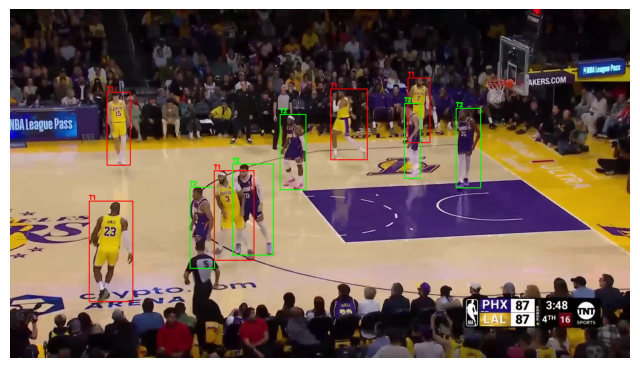

In [ ]:
def draw_team_boxes(frame, player_boxes, player_team):
    img_vis = frame.copy()

    for idx, box in enumerate(player_boxes):
        x1, y1, x2, y2 = map(int, box)
        if idx not in player_team:
            color = (128, 128, 128)  # gray if no team
        else:
            team_id = player_team[idx]
            color = (0, 0, 255) if team_id == 0 else (0, 255, 0)  # BGR: red vs green

        cv2.rectangle(img_vis, (x1, y1), (x2, y2), color, 2)
        cv2.putText(
            img_vis,
            f"T{team_id+1}",
            (x1, y1 - 5),
            cv2.FONT_HERSHEY_SIMPLEX,
            0.6,
            color,
            2,
            cv2.LINE_AA
        )
    return img_vis

vis = draw_team_boxes(frame_prev, player_boxes_prev, player_team)

import matplotlib.pyplot as plt
plt.figure(figsize=(8, 8))
plt.imshow(cv2.cvtColor(vis, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.show()


In [ ]:
import numpy as np
import cv2

def grabcut_player_from_box_smart(frame, box, court_mask=None,
                                  margin=10, fg_shrink=0.6, iters=5):
    """
    frame: (H, W, 3) BGR image
    box: [x1, y1, x2, y2] from YOLO (player box)
    court_mask: optional (H, W) uint8 mask of the court (1 = court, 0 = non-court)
    margin: small extension around the box
    fg_shrink: how much to shrink the sure-foreground inside the box (0.6 = 60%)
    iters: GrabCut iterations
    """
    H, W = frame.shape[:2]
    x1, y1, x2, y2 = map(int, box)

    # 1) ROI slightly around the box
    x1e = max(x1 - margin, 0)
    y1e = max(y1 - margin, 0)
    x2e = min(x2 + margin, W - 1)
    y2e = min(y2 + margin, H - 1)

    roi = frame[y1e:y2e, x1e:x2e].copy()
    h_roi, w_roi = roi.shape[:2]

    # 2) Init mask with "probable background"
    mask = np.full((h_roi, w_roi), cv2.GC_PR_BGD, dtype=np.uint8)

    # 3) Define an INNER rectangle as sure foreground (shrunk box)
    box_w = x2 - x1
    box_h = y2 - y1

    cx = (x1 + x2) / 2.0
    cy = (y1 + y2) / 2.0

    fg_w = int(box_w * fg_shrink)
    fg_h = int(box_h * fg_shrink)

    fg_x1 = int(cx - fg_w / 2.0) - x1e
    fg_y1 = int(cy - fg_h / 2.0) - y1e
    fg_x2 = fg_x1 + fg_w
    fg_y2 = fg_y1 + fg_h

    # Clamp inside ROI
    fg_x1 = max(fg_x1, 0)
    fg_y1 = max(fg_y1, 0)
    fg_x2 = min(fg_x2, w_roi)
    fg_y2 = min(fg_y2, h_roi)

    mask[fg_y1:fg_y2, fg_x1:fg_x2] = cv2.GC_FGD  # sure foreground (player core)

    # 4) Use court_mask to kill crowd/stands as sure background (if provided)
    if court_mask is not None:
        court_roi = court_mask[y1e:y2e, x1e:x2e]
        # wherever there is NO court, mark sure background
        mask[court_roi == 0] = cv2.GC_BGD

    bgdModel = np.zeros((1, 65), np.float64)
    fgdModel = np.zeros((1, 65), np.float64)

    # 5) Run GrabCut in MASK mode (rect is dummy)
    cv2.grabCut(
        roi, mask, (0, 0, 1, 1),
        bgdModel, fgdModel,
        iters,
        cv2.GC_INIT_WITH_MASK
    )

    # 6) Binary mask: FGD + PR_FGD
    roi_player_mask = np.where(
        (mask == cv2.GC_FGD) | (mask == cv2.GC_PR_FGD),
        1, 0
    ).astype("uint8")

    # 7) Paste back to full-frame mask
    full_mask = np.zeros((H, W), dtype=np.uint8)
    full_mask[y1e:y2e, x1e:x2e] = roi_player_mask

    player_rgb = frame * full_mask[:, :, None]

    return full_mask, player_rgb


In [ ]:
import numpy as np
import cv2

def player_color_feature_lab(frame, box, full_mask, shrink=0.6, min_pixels=50):
    """
    frame: (H, W, 3) BGR
    box: [x1, y1, x2, y2]
    full_mask: (H, W) binary mask for that player (0/1)
    shrink: keep only central part of the box to avoid overlaps
    """
    H, W = frame.shape[:2]
    x1, y1, x2, y2 = map(int, box)
    x1 = max(0, x1); y1 = max(0, y1)
    x2 = min(W, x2); y2 = min(H, y2)

    # --- compute inner box (shrunk) ---
    w = x2 - x1
    h = y2 - y1
    cx = (x1 + x2) / 2.0
    cy = (y1 + y2) / 2.0

    iw = int(w * shrink)
    ih = int(h * shrink)

    ix1 = int(cx - iw / 2.0)
    iy1 = int(cy - ih / 2.0)
    ix2 = ix1 + iw
    iy2 = iy1 + ih

    ix1 = max(ix1, 0); iy1 = max(iy1, 0)
    ix2 = min(ix2, W); iy2 = min(iy2, H)

    roi = frame[iy1:iy2, ix1:ix2]
    roi_mask = full_mask[iy1:iy2, ix1:ix2]

    ys, xs = np.where(roi_mask == 1)
    if len(ys) < min_pixels:
        return None

    roi_lab = cv2.cvtColor(roi, cv2.COLOR_BGR2LAB)
    L, A, B = cv2.split(roi_lab)

    a_vals = A[ys, xs].astype(np.float32)
    b_vals = B[ys, xs].astype(np.float32)

    # you can also try median to be more robust:
    a_mean = float(np.median(a_vals))
    b_mean = float(np.median(b_vals))

    return np.array([a_mean, b_mean], dtype=np.float32)


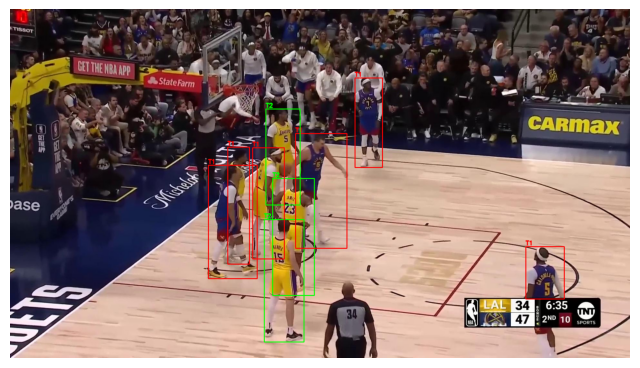

In [ ]:
frame_prev = cv2.imread(img_prev_path)

player_boxes_prev = load_yolo_player_boxes(
    label_prev_path,
    frame_prev.shape,
    player_class_id=3
)

# if you have a court mask, put it here, else None
court_mask_prev = None  # or your real mask

player_masks = []    # one full-image mask per *valid* player
features = []        # [a_mean, b_mean]
valid_indices = []   # indices in player_boxes_prev

for idx, box in enumerate(player_boxes_prev):
    # 1) grabcut with your new smart function
    mask_i, _ = grabcut_player_from_box_smart(
        frame_prev,
        box,
        margin=10,       # you can keep 20 if you want
        fg_shrink=0.6,   # whatever you set inside your func
        iters=5,
        court_mask=court_mask_prev
    )

    # 2) extract LAB feature with your function
    feat = player_color_feature_lab(
        frame_prev,
        box,
        mask_i,
        # min_pixels=50  # only if your version has this arg
    )

    if feat is not None:
        player_masks.append(mask_i)
        features.append(feat)
        valid_indices.append(idx)

# turn list → array for kmeans
features = np.array(features, dtype=np.float32)

# 3) cluster only if we have enough valid players
if len(features) >= 2:
    team_labels_small, centers = cluster_players_into_teams(features, K=2)
else:
    team_labels_small = np.array([], dtype=int)

# 4) map team labels back to original player indices
player_team = {}  # key: original index, value: team id

for local_i, orig_idx in enumerate(valid_indices):
    if len(team_labels_small) > 0:
        player_team[orig_idx] = int(team_labels_small[local_i])
    else:
        player_team[orig_idx] = -1  # unknown / no cluster

# 5) draw
vis = draw_team_boxes(frame_prev, player_boxes_prev, player_team)

plt.figure(figsize=(8, 8))
plt.imshow(cv2.cvtColor(vis, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.show()
